In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy.linalg import norm
from time import time
import h5py

## Load in form factor coefficients and define atomic form factor generating functions

In [2]:
form_factors={}
with open('atomic_FF_coeffs_clean.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        vals = line.split(',')
        element = vals[0]
        coeffs = [float(val) for val in vals[1:]]
        form_factors[element] = coeffs

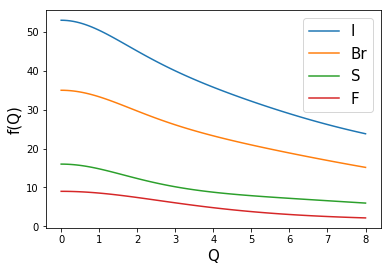

53.000600000000006


In [3]:
def load_form_fact(Element):
    coeffs = form_factors[Element]
    
    t1 = lambda q: coeffs[0]*np.exp(-1*coeffs[1]*(norm(q,axis=-1)/(4*np.pi))**2)
    t2 = lambda q: coeffs[2]*np.exp(-1*coeffs[3]*(norm(q,axis=-1)/(4*np.pi))**2)
    t3 = lambda q: coeffs[4]*np.exp(-1*coeffs[5]*(norm(q,axis=-1)/(4*np.pi))**2)
    t4 = lambda q: coeffs[6]*np.exp(-1*coeffs[7]*(norm(q,axis=-1)/(4*np.pi))**2) + coeffs[8]
    
    ff = lambda q: t1(q)+t2(q)+t3(q)+t4(q)
    
    return ff

def load_xyz(filepath):
    with open(filepath,'r') as f:
        lines = f.readlines()
        numel_line = lines[0].strip()
        numel = int(numel_line[0])
        atoms = []
        for line in lines[2:]:
            line = line.strip()
            splitline = line.split()
            atom = [splitline[0]]
            for i in range(1,4):
                atom.append(float(splitline[i]))
            atoms.append(atom)
    return atoms

Q = np.expand_dims(np.linspace(0,8,100),-1)

ff_I = load_form_fact('I')
ff_Br = load_form_fact('Br')
ff_S = load_form_fact('S')
ff_F = load_form_fact('F')

plt.figure(figsize=(6,4))
plt.plot(Q,ff_I(Q),label='I')
plt.plot(Q,ff_Br(Q),label='Br')
plt.plot(Q,ff_S(Q),label='S')
plt.plot(Q,ff_F(Q),label='F')
plt.legend(fontsize=15)
plt.xlabel('Q',fontsize=15)
plt.ylabel('f(Q)',fontsize=15)
plt.show()
print ff_I([0,0,0])

## Define X-ray parameters

In [4]:
joule_per_ev = 1.6e-19
pulse_energy = 1.2e-3
photon_energy = 9.8e3
dx = 75e-6
pixel_area = dx*dx
wavelength = 1240/photon_energy
n_photons = pulse_energy/(joule_per_ev*photon_energy)

numpoints_theta = 50
theta = np.linspace(0.001,np.pi/3,numpoints_theta)

def theta_to_q(theta):
    return 4*np.pi*np.sin(theta/2.)/(wavelength*10)
def q_to_theta(q):
    return 2*np.arcsin((wavelength*10*q)/(4*np.pi))
def generate_qgrid(theta):
    thetamax = np.max(np.abs(theta))
    qmax = theta_to_q(thetamax)
    q = np.linspace(-qmax, qmax, 2*len(theta)+1)
    qx, qy = np.meshgrid(q,q)
    Q_abs = np.sqrt(qx**2+qy**2)
    phigrid = np.arctan2(qy,qx)
    thetagrid = q_to_theta(Q_abs)
    QQr = Q_abs*np.cos(thetagrid/2)
    QQx, QQy = QQr*np.cos(phigrid), QQr*np.sin(phigrid)
    QQz = Q_abs*np.sin(thetagrid/2)
    QQ = np.stack((QQx,QQy,QQz),axis=-1)
    return QQ
    

q = theta_to_q(theta)
print np.min(q), np.max(q)

0.004965743019735966 4.965743226641931


## Define aligned molecular form factor from .xyz file

In [5]:
def mol_form_factor(xyz, QQ):
    output = np.zeros(QQ.shape[:-1],dtype=complex)
    for i in range(len(xyz)):
        for j in range(len(xyz)):
            atom1 = xyz[i]
            atom2 = xyz[j]
            xyz1 = np.array([atom1[1],atom1[2],atom1[3]])
            xyz2 = np.array([atom2[1],atom2[2],atom2[3]])

            ff1 = load_form_fact(atom1[0])
            ff2 = load_form_fact(atom2[0])
            func = lambda q: ff1(QQ)*np.conj(ff2(QQ))*np.exp(1j*np.dot(QQ,xyz1-xyz2))
            output += func(QQ)
            
    return output

## Load aligned molecular form factor

In [6]:
molecule = 'SF6'
xyz = load_xyz('/cds/home/i/igabalsk/xray/diffraction_simulation/%s.xyz' % molecule)
print len(xyz)
for item in xyz:
    print item
QQ = generate_qgrid(theta)
QQx, QQy, QQz = QQ[:,:,0], QQ[:,:,1], QQ[:,:,2]

7
['S', 0.0, 0.0, 0.0]
['F', -1.56227, 0.0, 0.0]
['F', 0.0, 1.56227, 0.0]
['F', 0.0, -1.56227, 0.0]
['F', 0.0, 0.0, 1.56227]
['F', 0.0, 0.0, -1.56227]
['F', 1.56227, 0.0, 0.0]


In [30]:
t0 = time()
aligned_form_factor = mol_form_factor(xyz,QQ)
t1 = time()
numpoints_euler_angles = 20
print 'Estimated time (min): ',(t1-t0)*numpoints_euler_angles**3/60

Estimated time (min):  30.569712321


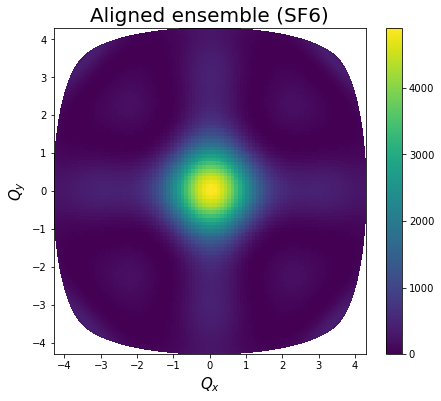

In [31]:
plt.figure(figsize=(7,6))
plt.pcolormesh(QQx,QQy,np.abs(aligned_form_factor))
plt.colorbar()
plt.xlabel(r'$Q_x$',fontsize=15)
plt.ylabel(r'$Q_y$',fontsize=15)
plt.title('Aligned ensemble (%s)' % molecule, fontsize=20)
# plt.savefig('aligned_scattering_%s.png' % molecule, bbox_inches='tight')
plt.show()

## Generate isotropic scattering by averaging over Euler angles

In [32]:
from scipy.spatial.transform import Rotation as R

def isotropic_scattering(xyz,QQ,symmetries=None):
    '''
    Parameters
    ----------
    xyz : list of lists, each of which contains a string specifying atomic species and three coordinates
    QQ : numpy array, (Nx,Ny,3) in shape specifying (Qx,Qy,Qz) values
    symmetries : None or list of three angle values specifying discrete angular symmetries
    '''
    alpha = np.linspace(0,2*np.pi,numpoints_euler_angles)
    beta = np.linspace(0,np.pi,numpoints_euler_angles)
    gamma = np.linspace(0,2*np.pi,numpoints_euler_angles)
    
    if symmetries is not None:
        alpha = np.linspace(0,symmetries[0],numpoints_euler_angles)
        beta = np.linspace(0,symmetries[1],numpoints_euler_angles)
        gamma = np.linspace(0,symmetries[2],numpoints_euler_angles)
    
    dalpha = np.mean(np.diff(alpha))
    dbeta = np.mean(np.diff(beta))
    dgamma = np.mean(np.diff(gamma))
    
    output = np.zeros(QQ.shape[:-1],dtype=complex)
    for i,a in enumerate(alpha):
        print i
        t0 = time()
        for b in beta:
            for g in gamma:
                xyz_prime = []
                rot = R.from_euler('ZXZ',[a,b,g])
                for atom in xyz:
                    pos = np.array([atom[1],atom[2],atom[3]])
                    pos_prime = rot.apply(pos)
                    xyz_prime.append([atom[0],pos_prime[0],pos_prime[1],pos_prime[2]])
                output += 1/(8*np.pi**2)*np.sin(b)*dalpha*dbeta*dgamma*mol_form_factor(xyz_prime,QQ)
        t1 = time()
    return output

def isotropic_theory(xyz,QQ):
    output = np.zeros(QQ.shape[:-1],dtype=float)
    for atom in xyz:
        output += np.abs(load_form_fact(atom[0])(QQ))**2
    for i in range(len(xyz)):
        for j in range(i+1,len(xyz)):
            atom1 = xyz[i][0]
            atom2 = xyz[j][0]
            xyz1 = np.array(xyz[i][1:])
            xyz2 = np.array(xyz[j][1:])
            ff1 = load_form_fact(atom1)
            ff2 = load_form_fact(atom2)
            r_ij = norm(xyz1-xyz2)
            output += 2*np.abs(ff1(QQ)*ff2(QQ))*np.sinc(1/np.pi*norm(QQ,axis=-1)*r_ij)
    return output

In [33]:
# isotropic_scattering_2d = isotropic_scattering(xyz,QQ,symmetries=[np.pi/2,np.pi/2,np.pi/2])
isotropic_theory_2d = isotropic_theory(xyz,QQ)
isotropic_scattering_2d = isotropic_theory(xyz,QQ)

In [34]:
QQ_norm = norm(QQ,axis=-1)
isotropic_scattering_1d = []
isotropic_theory_1d = []
QQ_1d = np.linspace(np.min(QQ_norm),np.max(QQ_norm),51)
dQQ_1d = np.mean(np.diff(QQ_1d))
QQ_1d = QQ_1d[:-1]
for qval in QQ_1d:
    isotropic_scattering_1d.append(np.mean(isotropic_scattering_2d[(QQ_norm>qval)&(QQ_norm<qval+dQQ_1d)]))
    isotropic_theory_1d.append(np.mean(isotropic_theory_2d[(QQ_norm>qval)&(QQ_norm<qval+dQQ_1d)]))

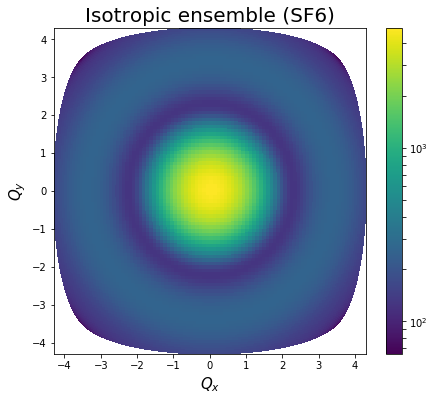

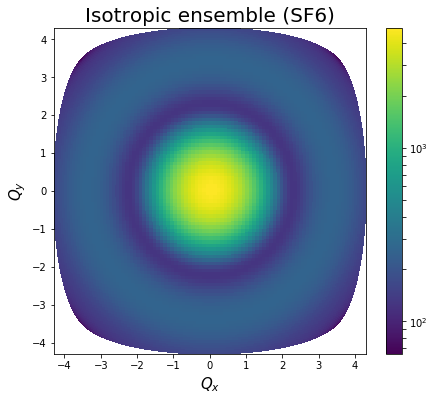

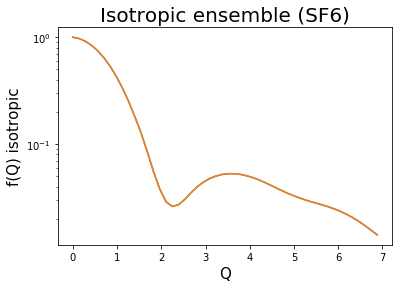

In [35]:
plt.figure(figsize=(7,6))
plt.pcolormesh(QQx,QQy,np.abs(isotropic_scattering_2d),
              norm=colors.LogNorm())
plt.colorbar()
plt.xlabel(r'$Q_x$',fontsize=15)
plt.ylabel(r'$Q_y$',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
# plt.savefig('isotropic_scattering_2d_%s.png' % molecule, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,6))
plt.pcolormesh(QQx,QQy,np.abs(isotropic_theory_2d),
              norm=colors.LogNorm())
plt.colorbar()
plt.xlabel(r'$Q_x$',fontsize=15)
plt.ylabel(r'$Q_y$',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
# plt.savefig('isotropic_scattering_2d_%s.png' % molecule, bbox_inches='tight')
plt.show()

plt.figure()
plt.semilogy(QQ_1d, np.abs(isotropic_scattering_1d)/np.abs(isotropic_scattering_1d[0]))
plt.semilogy(QQ_1d, np.abs(isotropic_theory_1d)/isotropic_theory_1d[0])
plt.xlabel('Q',fontsize=15)
plt.ylabel('f(Q) isotropic',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
# plt.savefig('isotropic_scattering_1d_%s.png' % molecule, bbox_inches='tight')
plt.show()

In [36]:
with h5py.File('isotropic_scattering_%s.h5' % molecule,'w') as h:
    h.create_dataset('QQ', data=QQ)
    h.create_dataset('QQx', data=QQx)
    h.create_dataset('QQy', data=QQy)
    h.create_dataset('QQz', data=QQz)
    h.create_dataset('isotropic_scattering_2d', data=isotropic_scattering_2d)
    h.create_dataset('QQ_1d', data=QQ_1d)
    h.create_dataset('isotropic_scattering_1d', data=isotropic_scattering_1d)

### Check that files were properly written

In [24]:
with h5py.File('isotropic_scattering_%s.h5' % molecule,'r') as f:
    for name, data in f.items():
        print name, (f[name].value).shape

QQ (101, 101, 3)
QQ_1d (50,)
QQx (101, 101)
QQy (101, 101)
QQz (101, 101)
isotropic_scattering_1d (50,)
isotropic_scattering_2d (101, 101)


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()


## Manipulate molecule of interest

In [26]:
molecule = 'SF6'
isotropic_scattering_dict = {}
with h5py.File('isotropic_scattering_%s_old.h5' % molecule,'r') as f:
    for name, data in f.items():
        isotropic_scattering_dict[name]=f[name].value
        print name
        
from scipy.interpolate import interp1d

ff = interp1d(QQ_1d,np.abs(isotropic_scattering_dict['isotropic_scattering_1d']))
def form_factor(q):
    output = np.zeros_like(q)
    output[q>np.max(QQ_1d)] = ff(np.max(QQ_1d))
    output[q<np.min(QQ_1d)] = ff(np.min(QQ_1d))
    output[(q<=np.max(QQ_1d))&(q>=np.min(QQ_1d))] = ff(q[(q<=np.max(QQ_1d))&(q>=np.min(QQ_1d))])
    return output

qs = np.linspace(np.min(QQ_1d)+0.0001,np.max(QQ_1d),1000)
Q = np.expand_dims(qs,-1)
f1 = isotropic_theory_1d
f2 = np.abs(isotropic_scattering_1d)
plt.figure()
plt.semilogy(qs, f1/f1[0],label='Theory')
plt.semilogy(QQ_1d, f2/f2[0],label='Ian\'s Method')
plt.xlabel('Q',fontsize=15)
plt.ylabel('f(Q) isotropic',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('isotropic_scattering_1d_%s.png' % molecule, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,6))
plt.pcolormesh(QQx,QQy,form_factor(norm(QQ,axis=-1)),
              norm=colors.LogNorm())
plt.colorbar()
plt.xlabel(r'$Q_x$',fontsize=15)
plt.ylabel(r'$Q_y$',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
# plt.savefig('isotropic_scattering_2d_%s.png' % molecule, bbox_inches='tight')
plt.show()

KeyError: 'isotropic_scattering_1d'